# Machine Learning LAB 4: Soft SVM

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement a **SOFT SUPPORT VECTOR MACHINE**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Classification of Stayed/Churned Customers

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. Companies are naturally interested in churn, i.e., in which users are likely to switch to another company soon to get a better deal, and which are more loyal customers.

The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

---

## Import all the necessary Python libraries and load the dataset

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

## Divide the data into training and test sets

In [2]:
# Compute the splits
m_training = int(0.75*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test =  X.shape[0] - m_training
X_training =  X[:m_training]
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("Number of churned users in test:", np.sum(Y_test==-1))
print("Number of loyal users in test:", np.sum(Y_test==1))

# Standardize the input matrix
# The transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940
Number of churned users in test: 479
Number of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [3]:
def to_homogeneous(X_training, X_test):
    Xh_training = np.hstack([np.ones( (X_training.shape[0], 1) ), X_training])
    Xh_test = np.hstack([np.ones( (X_test.shape[0], 1) ), X_test])
    return Xh_training, Xh_test

In [4]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


## Soft SVM with stochastic gradient descent

Now **complete** the function *sgd_soft_svm* and all auxiliary functions. <br>
You should select *a single sample*, compute the gradient, and run the soft SVM version.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the soft SVM
- $averaging\_iterations$: the number of iterations to consider when averaging

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $margin$: the *margin* of the best model
- $outliers$: the number of outliers that are classified correctly by the best model
- $misclassified$: the number of outliers that are misclassified by the best model

In [34]:
from numpy.linalg import norm

def find_margin(current_w):  
    # TODO Return the margin for the selected model
    margin = np.max([1/ norm(current_w), 10e-9]) # a tolerance to prevent division by zero
    return margin
    

def count_outliers(current_w, X, Y):
    """
    Returns the absolute number of total samples inside the margin (n_outliers) and missclassified samples (n_misclassified)
    """
    # TODO Return a tuple containing 2 numbers:
    # First, the number of total outliers (distance below the margin)
    # Second, the number of misclassified outliers
    margin = find_margin(current_w) # a tolerance to prevent division by zero
    signed_distances = np.dot(X, current_w) * Y
    tot_outliers_mask = ( signed_distances < margin )
    n_outliers = len(signed_distances[tot_outliers_mask])
    misclassified_outliers_mask = ( signed_distances < 0 )
    n_misclassified= len(signed_distances[misclassified_outliers_mask])
    return (n_outliers, n_misclassified)

    

def sgd_soft_svm(X: np.ndarray, Y: np.ndarray, lambda_par: float, max_num_iterations: int, averaging_iterations: int):
    # TODO complete function
    """
    Returns:
    - best_w: weight vector 
    - margin: margin_width corresponding to best_w
    - outliers_tuple: fraction of samples inside margin (outliers_tuple[0]) and misclassified (outliers_tuple[1])
    """
    # Initialize the weights of the algorith with w=0
    theta = np.zeros(X.shape[1])
    best_w = np.zeros(X.shape[1])
    num_samples = X.shape[0]

    w_sum = np.zeros(X.shape[1])
    # Loop the SGD algorithm
    for num_iter in range(1, max_num_iterations):
        # Compute the current weights
        current_w = ( 1/ (lambda_par * num_iter) ) * theta
        # Compute the gradient over a random point
        i = np.random.choice(np.arange(0, num_samples), size = 1)
        signed_distance = Y[i] * np.dot(X[i, :], current_w)
        if signed_distance < 1:
            # outlier
            theta += Y[i] * X[i, :].flatten() # without flatten, X has shape (1, 4) while theta (4, )
        if (num_iter - 1 >= max_num_iterations - averaging_iterations):
            # Use the current model for averaging
            w_sum += current_w
    best_w = w_sum/ averaging_iterations # maybe to be normalized?
    margin = find_margin(best_w)
    outliers_fraction_tuple = np.asarray(count_outliers(best_w, X, Y))/ len(X)
    return best_w, margin, outliers_fraction_tuple

Now we use the implementation to learn a model from the training data using 100000 iterations and averaging over the last 10000. Let us consider $\lambda=1$. Then we use the best model $best\_w$ to **predict the labels for the test dataset** and print the fraction of outliers in the test set (the test error that is an estimate of the true loss).

In [33]:

# Now run the Soft SVM with lambda=0.1. Consider 100000 iterations, 10000 of which are avera
best_w, margin, outliers_tuple = sgd_soft_svm(X_training, Y_training, 0.1, int(1e5), int(1e4))
print("Soft SVM model: " + str(best_w))
print("Soft SVM margin: " + str(margin), end= '\n\n')
print("Total outlier fraction: " + str(outliers_tuple[0]))
print("Misclassified points fraction: " + str(outliers_tuple[1]), '\n')

true_error = np.asarray(count_outliers(best_w, X_test, Y_test))/ len(X_test)
print("Total outlier fraction (test set): " + str(true_error[0]))
print("True loss (test set): " + str(true_error[1])) #only misclassified points count as errors

Soft SVM model: [ 0.01736695 -0.9051096   0.40795861  0.13020333]
Soft SVM margin: 0.9985490928387598

Total outlier fraction: 0.6872559460418886
Misclassified points fraction: 0.26091586794462196 

Total outlier fraction (test set): 0.7053191489361702
True loss (test set): 0.2531914893617021


Now let us compare the result with your perceptron function from Lab 2.

In [7]:
def perceptron_randomized_update(current_w, X, Y):
    # TODO: write the perceptron update function
    n, index = count_errors_perceptron(current_w, X, Y)
    if n > 0:
        i = np.random.choice(index, size = 1)
        current_w += X[i, :].flatten() * Y[i]
    return current_w

def count_errors_perceptron(current_w, X, Y):
    # Find all indices which have a different sign from the corresponding labels
    index = np.nonzero(np.sign(np.dot(X, current_w)) - Y)[0]
    n = len(index)
    if (n == 0):
        # There are no misclassified samples
        return 0, -1
    return n, index

def perceptron_with_randomization(X:np.ndarray, Y:np.ndarray, max_num_iterations: int):
    # TODO: write the perceptron main loop
    current_w = np.zeros(X.shape[1])
    best_w = np.zeros(X.shape[1])
    best_error = 10e5
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0
    for _ in np.arange(max_num_iterations):
        current_w = perceptron_randomized_update(current_w, X, Y)
        current_error, _ = count_errors_perceptron(current_w, X, Y)
        if current_error == 0:
            # found an ERM solution
            best_w = current_w.copy()
            best_error = current_error
            break
        if current_error < best_error:
            best_w = current_w.copy()
            best_error = current_error
    return best_w, best_error

Let us test the error of the Soft SVM against the perceptron's best model, using 1000 iterations.

In [8]:
w_found, error = perceptron_with_randomization(X_training, Y_training, 1000)
print("Training Error of perceptron: " + str(error))
print("Best perceptron model: " + str(w_found))
true_loss_estimate =  count_errors_perceptron(w_found, X_test, Y_test)[0] / len(Y_test)    # Error rate on the test set    
print("Test Error of perceptron: " + str(true_loss_estimate))

Training Error of perceptron: 694
Best perceptron model: [ 0.         -1.20686228  0.68675011  0.35239205]
Test Error of perceptron: 0.24574468085106382


Now we can try to see the effect of $\lambda$. Consider values $10, 1, 0.1, 0.01, 0.001$ and run a K-fold cross validation (you can use the code from Lab 3). Plot the margin and outlier count. Use the loss (i.e., the number of misclassified points) as a score.


**Remember**: $\lambda \rightarrow 0 $: hard SVM, $\lambda \rightarrow +\infty $: very soft SVM

In [43]:
def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray, max_num_iterations: int, averaging_iterations: int) -> np.ndarray:
    ## TODO: Perform K-fold cross-validation
    """
    This function assumes that the data X is passed as a matrix with nrows = nsamples, ncols = nfeatures
    Returns:
    - best_results (tuple): best weights (best_results[0]) and their corresponding lambda parameter (weight[1])
    - lambda_scores (list) : average fraction of missclassified samples in the validation set
    - margin_list (list): margin computed over the whole training dataset
    - 
    """
    idxs = np.arange(0, X_training.shape[0])
    np.random.shuffle(idxs)
    idxs_folds = np.array_split(idxs, K)
    lambda_validation_scores = []
    margin_list = []
    tot_outliers_fraction_list = []
    misclassified_fraction_list = []
    for lambda_par in lambda_vec:
        # First fit using the whole set (it is requested by the exercise)
        _, margin, outliers_fraction_tuple = sgd_soft_svm(X_training, Y_training, lambda_par, max_num_iterations, averaging_iterations)
        margin_list.append(margin)
        tot_outliers_fraction_list.append(outliers_fraction_tuple[0])
        misclassified_fraction_list.append(outliers_fraction_tuple[1])

        # Now do the K-fold validation
        score = 0
        for k in range(K):
            X_validation_fold = X_training[idxs_folds[k], :]
            Y_validation_fold = Y_training[idxs_folds[k]]
            idxs_training_fold = np.array( list(set(idxs) - set(idxs_folds[k])) )
            X_training_fold = X_training[idxs_training_fold, :]
            Y_training_fold = Y_training[idxs_training_fold]
            # Learn the weight on the training fold
            w_fold, _, _ = sgd_soft_svm(X_training_fold, Y_training_fold, lambda_par, max_num_iterations, averaging_iterations)
            # Evaluate error on the validation fold
            outliers_tuple = count_outliers(w_fold, X_validation_fold, Y_validation_fold)
            score += outliers_tuple[1]/ len(Y_validation_fold)
        score /= K
        lambda_validation_scores.append(score)
    lambda_best = lambda_vec[np.argmin(lambda_validation_scores)]
    w_best,_ , _ = sgd_soft_svm(X_training, Y_training, lambda_best, max_num_iterations, averaging_iterations)
    best_results = (w_best, lambda_best)
    training_outliers_fraction = (tot_outliers_fraction_list, misclassified_fraction_list)
    return best_results, lambda_validation_scores, margin_list, training_outliers_fractionx


In [44]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = [10, 1, 1e-1, 1e-2, 1e-3]

best_results, lambda_scores, margin_list, outliers = K_fold(X_training, Y_training, lambda_par, K,  int(1e5), int(1e4))


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1314/4117506734.py:7: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_xlabel('$\log(\lambda)$')
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1314/4117506734.py:13: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel('$\log(\lambda)$')


Text(0, 0.5, 'Margin width')

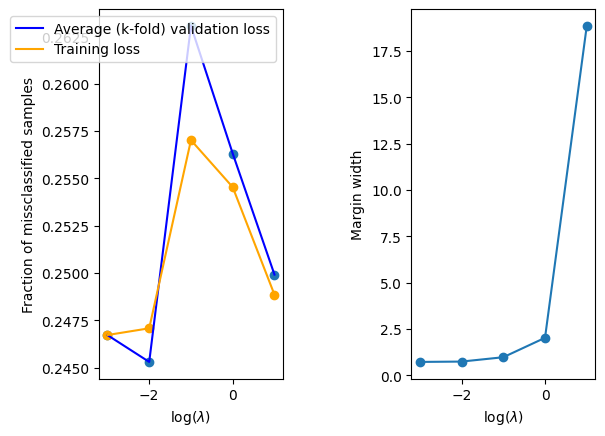

In [51]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
plt.subplots_adjust(wspace = 0.7)
axs[0].scatter(np.log10(lambda_par),lambda_scores)
axs[0].plot(np.log10(lambda_par),lambda_scores, color = 'blue', label= 'Average (k-fold) validation loss')
axs[0].scatter(np.log10(lambda_par),outliers[1], color = 'orange')
axs[0].plot(np.log10(lambda_par),outliers[1], color = 'orange', label= 'Training loss')
axs[0].set_xlabel('$\log(\lambda)$')
axs[0].set_ylabel('Fraction of missclassified samples')
axs[0].legend(loc = 'best')

axs[1].scatter(np.log10(lambda_par), margin_list)
axs[1].plot(np.log10(lambda_par), margin_list)
axs[1].set_xlabel('$\log(\lambda)$')
axs[1].set_ylabel('Margin width')


What does this tell you about the margins? Which one should you choose? 

*My Answer* the margin width is a monotonically increasing function of lambda. I expected that, because when $\lambda$ increases, the SVM becomes more and more "soft" i.e. allowing more samples inside the margin == enlarging the margin. The validation loss is minimum at $\lambda = 10e-2$ so I choose that one.


Now compute the test loss of the best Soft SVM. What does this tell you about the algorithm choice over this problem?

In [52]:
true_error = np.asarray(count_outliers(best_results[0], X_test, Y_test)) / len(Y_test)
print("Total outlier fraction (test set): " + str(true_error[0]))
print("True loss (test set): " + str(true_error[1]))

Total outlier fraction (test set): 0.5255319148936171
True loss (test set): 0.2478723404255319


*My answer* the test loss is almost identical to the validation loss, therefore the algorithm made a good choice.